In [1]:
import os
import numpy as np
import pandas as pd
import importlib
import ipywidgets as widgets
import datetime as dt

import stable_baselines3 as sb
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter

In [2]:
import cpagent
import cprender
import cpenvs
import cppid

_ = importlib.reload(cpagent)
_ = importlib.reload(cprender)
_ = importlib.reload(cpenvs)
_ = importlib.reload(cppid)

In [5]:
dir = f"../data/{dt.datetime.now().strftime('%Y%m%dT%H%M%SZ')}-ppo-moving/"
print(dir)
os.makedirs(dir, exist_ok=True)

def env_maker():
    return cpenvs.MovingCartpoleEnv(use_normalized_state=True)
env = make_vec_env(env_maker, n_envs=8, vec_env_cls=SubprocVecEnv, monitor_dir=dir)

model = sb.PPO("MlpPolicy", env, verbose=0, tensorboard_log=dir+"/tensorboard")

model.learn(total_timesteps=500_000, log_interval=4, progress_bar=True)
model.save(dir+ "model_ppo_moving")

../data/20240310T220255Z-ppo-moving/


Output()

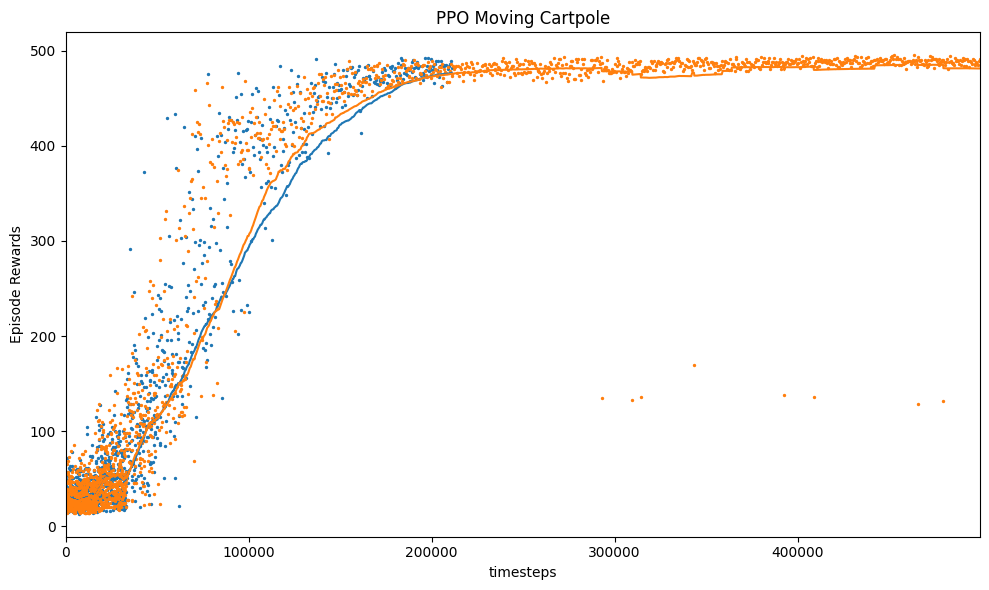

In [6]:
dirs = [
    "../data/20240310T215750Z-ppo-moving/", 
    "../data/20240310T220255Z-ppo-moving/"
]

results_plotter.plot_results(
    dirs,
    500_000,
    results_plotter.X_TIMESTEPS,
    "PPO Moving Cartpole",
    figsize=(10, 6)
)

In [8]:
model = sb.PPO.load(dirs[1]+ "/model_ppo_moving")
agent = cpagent.ModelCartPoleAgent(model)

df = cpagent.execute_cartpole(agent, cpenvs.MovingCartpoleEnv(use_normalized_state=True), num_episodes=100)
df

,ep,t,cart_pos,cart_vel,pole_ang,pole_vel,pos_deviation,force,reward,cart_pos_setpoint
0,0,0,-0.048483,-0.018916,0.025227,0.033156,-0.048483,0.0,NaN,0.000000
1,0,1,-0.048861,0.175836,0.025891,-0.251461,-0.048861,10.0,0.998806,0.000000
2,0,2,-0.045345,-0.019646,0.020861,0.049274,-0.045345,-10.0,0.998972,0.000000
3,0,3,-0.045738,0.175171,0.021847,-0.236754,-0.045738,10.0,0.998954,0.000000
4,0,4,-0.042234,-0.020257,0.017112,0.062739,-0.042234,-10.0,0.999108,0.000000
...,...,...,...,...,...,...,...,...,...,...
50095,99,496,0.882148,-0.030785,-0.000904,0.047319,-0.008424,-10.0,0.999965,0.890573
50096,99,497,0.881533,0.164350,0.000042,-0.245649,-0.009040,10.0,0.999959,0.890573
50097,99,498,0.884820,-0.030773,-0.004871,0.047047,-0.005753,-10.0,0.999983,0.890573
50098,99,499,0.884204,-0.225825,-0.003930,0.338189,-0.006369,-10.0,0.999980,0.890573


In [20]:
#df.groupby("ep")["reward"].sum().to_frame("ep_reward").sort_values(by="ep_reward")
#df.groupby("ep")["pole_ang"].min().to_frame("maxangle").sort_values(by="maxangle")

In [22]:
_ = widgets.interact(
    lambda ep, t: cprender.render_cartpole_state_df(df, t, ep),
    ep=widgets.IntSlider(min=0, max=20, step=1, value=0),
    t=widgets.IntSlider(min=0, max=500, step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='ep', max=20), IntSlider(value=0, description='t', max=50…

In [9]:
EP = 0

fig = cprender.lineplot(df, ep=EP, incl_velo=False)
fig.show()

In [10]:
agent_ref = cppid.PidAgentMoving2(
    (0.301, 0.0190, 0.0797),
    (0.0659, 0.00, 0.0499),
    1.33
)
df_ref = cpagent.execute_cartpole(agent_ref, env=cpenvs.MovingCartpoleEnv(), num_episodes=100)
df_ref

,ep,t,cart_pos,cart_vel,pole_ang,pole_vel,pos_deviation,force,reward,cart_pos_setpoint
0,0,0,-0.016735,-0.032630,-0.042675,-0.035057,-0.016735,0.0,NaN,0.000000
1,0,1,-0.017388,-0.227115,-0.043376,0.243863,-0.017388,-10.0,0.999849,0.000000
2,0,2,-0.021930,-0.421591,-0.038498,0.522554,-0.021930,-10.0,0.999760,0.000000
3,0,3,-0.030362,-0.616151,-0.028047,0.802862,-0.030362,-10.0,0.999539,0.000000
4,0,4,-0.042685,-0.420656,-0.011990,0.501489,-0.042685,10.0,0.999089,0.000000
...,...,...,...,...,...,...,...,...,...,...
50095,99,496,0.780111,-0.347047,-0.009320,0.515137,0.029418,-10.0,0.999567,0.750692
50096,99,497,0.773170,-0.151795,0.000983,0.219532,0.022478,10.0,0.999747,0.750692
50097,99,498,0.770134,0.043313,0.005373,-0.072841,0.019442,10.0,0.999811,0.750692
50098,99,499,0.771000,0.238357,0.003916,-0.363824,0.020308,10.0,0.999794,0.750692


[(450.0, 500.0)]

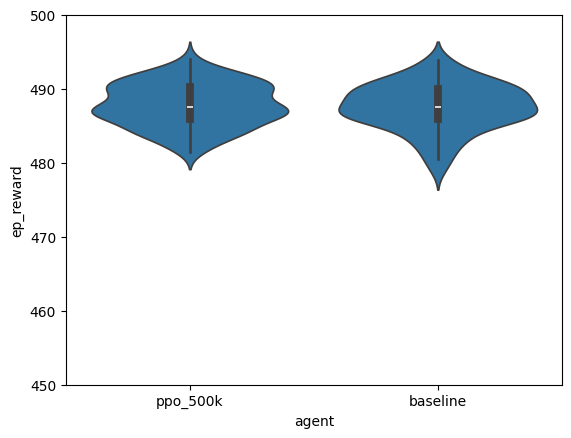

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as maxes


dfplt = df.groupby("ep")["reward"].sum().to_frame("ep_reward")
dfplt["agent"] = "ppo_500k"

dfplt_ref = df_ref.groupby("ep")["reward"].sum().to_frame("ep_reward")
dfplt_ref["agent"] = "baseline"

dfplt = pd.concat([dfplt, dfplt_ref])

fig, ax = plt.subplots()
ax:maxes.Axes = ax

sns.violinplot(
    dfplt,
    x="agent",
    y="ep_reward",
    orient="v",
    ax=ax
)

ax.set(ylim=(450.0, 500.0))